# Problema con sistema de tipo 1

In [1]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

Para el sistema :

$$ G(s) = \frac{10}{s\left(\frac{s}{2.5}+1\right)\left(\frac{s}{6}+1\right)} $$

Se requiere un sistema que tenga un margen de fase de 45 grados y una constante de velocidad $K_v=10$

In [2]:
s=ctrl.tf('s')
G1=10/((s/2.5+1)*(s/6+1)*s)

Analizamos los polos del sistema a lazo abierto

In [3]:
G1.pole()

array([-6. , -2.5,  0. ])

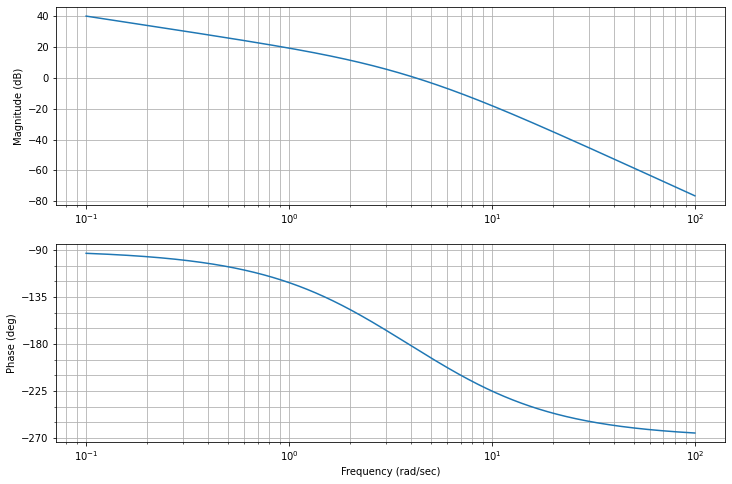

In [4]:
ctrl.bode(G1, dB=True);
plt.gcf().set_size_inches(12,8)

In [5]:
_,pm,_,_,wp,_=ctrl.stability_margins(G1)
print(pm,wp)

-4.170645874604446 4.195274375474061


In [6]:
ctrl.dcgain(ctrl.minreal(G1*s)) # el minreal es para simplificar el pole en cero y pueda evaluarla

1 states have been removed from the model


10.0

In [7]:
phi_max=(45+10-pm)
print(f"El ángulo máximo a agregar es {phi_max}")
phi_max = phi_max*np.pi/180
alpha = (1-np.sin(phi_max))/(1+np.sin(phi_max))
print(f"Esto produce un esto pruduce una relación z/p de {alpha}")

El ángulo máximo a agregar es 59.170645874604446
Esto produce un esto pruduce una relación z/p de 0.07602235029343364


Probamos poniendo el el $\omega_{max}$ en la frecuencia de corte.

In [8]:
wmax=wp
# phi_max=85

phi_max = phi_max*np.pi/180
alpha = (1-np.sin(phi_max))/(1+np.sin(phi_max))
alpha

0.9645913189500956

In [9]:
TD=1/(wmax*np.sqrt(alpha))

In [10]:
z=-1/TD
p=-1/(alpha*TD)
print(z, p)

-4.120330413615452 -4.271581479812823


In [11]:
Dc=ctrl.tf([-1/z,1],[-1/p,1])
ctrl.stability_margins(G1*Dc)

(0.8695227566999199,
 -3.595557766909508,
 0.05801531497067265,
 3.9502117427292607,
 4.232290647456006,
 4.1873242354745175)

Vemos que esto no sirve por que la curva de fase se baja demasiado. Deberíamos rediseñar.

In [12]:
wmax=12
phi_max=60*(np.pi)/180

alpha = (1-np.sin(phi_max))/(1+np.sin(phi_max))
TD=1/(wmax*np.sqrt(alpha))
z=-1/TD
p=z/alpha

Dc=ctrl.tf([-1/z,1],[-1/p,1])
print(Dc.zero(), Dc.pole(), Dc.dcgain(), alpha)

[-3.21539031] [-44.78460969] 1.0 0.07179676972449085


In [13]:
ctrl.stability_margins(G1*Dc)

(5.635923781559606,
 32.83177099437739,
 0.47471498757783986,
 15.283504622266324,
 5.813363382362743,
 7.019586651361187)

Vemos que no se puede llegar a los 45 grados de margen de fase con solo un compensador de adelanto.

Voy a probar con dos dejando el siguiente compensador:

In [14]:
wmax=9
phi_max=35*(np.pi)/180
alpha = (1-np.sin(phi_max))/(1+np.sin(phi_max))
TD=1/(wmax*np.sqrt(alpha))
z=1/TD
p=z/alpha

Dc1=ctrl.tf([1/z,1],[1/p,1])
print(Dc1.zero(), Dc1.pole(), Dc1.dcgain(), alpha)

[-4.68510345] [-17.28883914] 1.0 0.27099005412014443


Probamos con la misma idea:

In [15]:
wmax=10
phi_max=40*(np.pi)/180
alpha = (1-np.sin(phi_max))/(1+np.sin(phi_max))
TD=1/(wmax*np.sqrt(alpha))
z=1/TD
p=z/alpha


Dc2=ctrl.tf([1/z,1],[1/p,1])
print(Dc2.zero(), Dc2.pole(), Dc2.dcgain(), alpha)

[-4.66307658] [-21.44506921] 1.0 0.21744283205399909


In [16]:
ctrl.stability_margins(G1*Dc1*Dc2)

(5.11940378281518,
 45.178384292325745,
 0.5896895366180702,
 18.358679652988574,
 6.422352438438121,
 9.477339127527927)

In [17]:
T=ctrl.feedback(G1*Dc1*Dc2)
t,y = ctrl.step_response(T, T=np.linspace(0,2,2401))

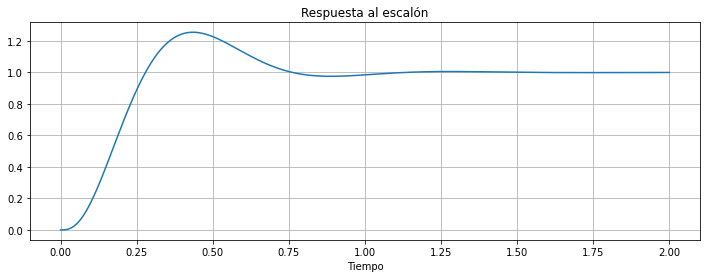

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t,y)
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo')
ax.grid()

In [19]:
T=ctrl.feedback(G1*Dc1*Dc2)
t,y = ctrl.step_response(T*ctrl.tf(1,[1,0]), T=np.linspace(0,500,2401))

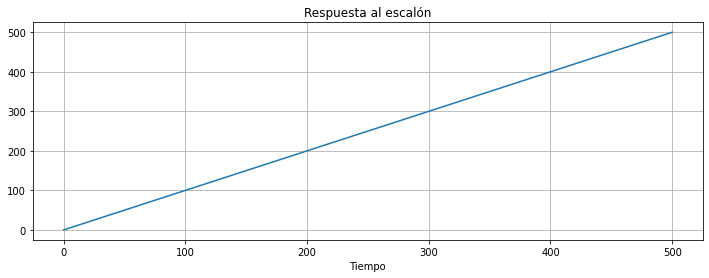

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t,y)
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo')
ax.grid()

In [21]:
error = y[-1]-t[-1]
print(error)

-0.10000000026320777


In [22]:
(Dc1*Dc2).pole()

array([-21.44506921, -17.28883914])

In [23]:
(Dc1*Dc2).zero()

array([-4.68510345, -4.66307658])